# **Sentiment Analysis Using Gated-Recurrent Neural Networks**

In this assignment, we will use the IMDB dataset that contains the text of 50,000 movie reviews from the Internet Movie Database (IMDB) website. The label of each movie review is either positive or negative. An example of the input-output pair in this dataset is

"*I happen to run into this movie one night so I decided to watch it ! I was very pleased with the movie ... I thought it was a wonderful plot . It 's a great feeling knowing a deceased one has come back and you get that second chance to say what you want to say ! And this wife stayed devoted for 23 years ! ! ! I thought it was a great movie ! !*"

where its label, as you might expect, is 
"*positive*".

**In this assignment, we want to design a classifier that takes as input a review and outputs whether it is a positive or negative review about a movie.**

In the next two cells, we import some modules and also fix some constants for our implementation. 

In [2]:
import csv
from typing import Callable, Tuple

import jax.numpy as jn
import matplotlib.pyplot as plt
import numpy as np
from jax import lax
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from tqdm import trange
from sklearn.model_selection import train_test_split
%pip --quiet install objax
import objax
from objax.typing import JaxArray


objax.random.DEFAULT_GENERATOR.seed(42)
np.random.seed(42)

     |████████████████████████████████| 50 kB 2.4 MB/s 


In [3]:
!gdown --id 11r58MB8wRBO1o1gEC-zxiADZIuwMnhf7

Downloading...
From: https://drive.google.com/uc?id=11r58MB8wRBO1o1gEC-zxiADZIuwMnhf7
To: /content/IMDB Dataset.csv
100% 66.2M/66.2M [00:00<00:00, 72.2MB/s]


In [4]:
max_vocab = 2000  # this parameter is for the maximum number of words in the "dictionary"
max_len = 200  # maximum length of each review
embedding_size = 30  # size of embedding
num_hidden_units_GRU = 30  # GRU cells in the RNN layer
num_hidden_units = 60  # hidden unit of dense network after GRU

vocab_size = max_vocab
filename = 'IMDB Dataset.csv'

# How to find a representation of sentences?
In order to put the words into the machine learning algorithm the text data should be converted into a vector representation. The first approach that comes to mind is *one hot encoding*.
 # One Hot Encoding
Assume that we count the number of english words in the Merriam-Webster dictionary, and it turns out that the total number of words is $N$. Then, a possible way to represent the words is to use binary vectors of size $N$. Each integer value is represented as a binary vector that is all zero values except the index of the integer, which is marked with a $1$.
As an example let's say all the words in the dictionary consists of $\{$apple, orange, Milan,Rome$\}$. For this example, the one hot encoding is given by:
 
apple = $[1,0,0,0]$ \\
orange = $[0,1,0,0]$ \\
Milan = $[0,0,1,0]$  \\
Rome = $[0,0,0,1]$
 
We can also represent each word by an integer: for instance in the above-mentioned example, the mapping is apple $\rightarrow$ 1, orange $\rightarrow$ 2, Milan $\rightarrow$ 3,  Rome $\rightarrow$ 4.
 



When we are working with a dataset, a practical approach for one-hot encoding of the data is as follows:
 
1.  First, we can create a dictionary which shows each word along with its frequency in the dataset. For example, if the sentence is "Put the books on the table." , we need to create a dictionary such that word_index["Put"] = 1; word_index["the"] = 2; word_index["books"] = 1; word_index["on"] = 1; word_index["table"] = 1.
2.  Second, based on the maximum size of the vocabulary we want, we can sort the words based on their frequency and only pick the most frequent words of this maximum size of the vocabulary, and this creates our dictionary. So lower integer means more frequent word (often the first few are stop words because they appear a lot)
 
3. Then, we can assign an integer to each word in the dictionary, and represent each sentence as a sequence of integers.
 
 
The following function performs the above-mentioned steps for our IMDB dataset.



In [5]:
def data_processing(filename, max_vocab, max_len):
  # filename: the name of the .csv file
  # max_vocab: The maximum number of words
  # max_len: 
  messages = []  # a list contains the reviews
  labels = []  # a list contains the labels
  with open(filename, 'r') as file:
      reader = csv.reader(file)
      firstline = True
      for row in reader:
        if firstline:
            firstline = False
            continue
        else:
            messages.append(row[0])
            labels.append(int(row[1]=='positive'))

  tokenizer = Tokenizer(num_words=max_vocab)
  tokenizer.fit_on_texts(messages) ## frequency dict
  messages_seq = tokenizer.texts_to_sequences(messages) ## convert to int sequences
  data = pad_sequences(messages_seq, maxlen=max_len)  ## 
  train_size = 0.8
  messages_train, messages_valid_test, labels_train, labels_valid_test  = train_test_split(data, labels, train_size=train_size)
  messages_valid, messages_test, labels_valid, labels_test  = train_test_split(messages_valid_test, labels_valid_test, train_size=0.5)
  return np.array(messages_train), np.array(labels_train), np.array(messages_valid), np.array(labels_valid), np.array(messages_test), np.array(labels_test)

For the data_processing function, we used Tokenizer which is a class in keras.preprocessing.text. The following questions are about the different methods in this class. \\



**Question 1** [1 points]: In your own words, explain what does "fit_on_texts" do? 

`fit_on_texts` transforms the input into a dictionary where the frequency of each word is counted. In this case, the keys of the dictionary are the words and the values are the corresponding frequency of the word.


**Question 2** [1 points]: In your own words, explain what does "texts_to_sequences" do? \\

After assigning an integer to each word, `texts_to_sequences` converts each review in the list of reviews into sequences of those integers. 

**Question 3** [1 points]: In your own words, explain what does "pad_sequences" do, and why do we need it? \\

`pad_sequences` takes the integer sequences from `text_to_sequences` as an input and converts it into a 2D NumPy array of a specific size. It pads the beginning of all sequences with 0s such that each list is the same length. 

In the next cell, we encode the data set using one-hot encoding, and split the dataset into the training set, validation set, and the test test.

In [6]:
messages_train, labels_train, messages_valid, labels_valid, messages_test, labels_test = data_processing(filename, max_vocab, max_len)

**Question 4** [1 points]: Print one of the inputs in the training set and explain your observation? Does it match with what you expected?

In [ ]:
print(messages_train[3])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0   11 1601  254    6    3  456 1925   16   32   35 1094  396    5
  969  122   24  123   31   47    4    1   22   80  123  125  519   20
    2   35   39  582    5   26    1  227   81    5    3  171 1738  806
   60   61  946    8   47  965 1195    3   60  508  776  271   32 1313
 1843 1414   35  508  542 1188  506   21    5  747    3  768  722   41
    4    1 1426    4  259    8   11  417    1  105 1783 1533    8    1
  127   10  185  131  145  760   12   11   19  276   54    4    1    4
   15    1   60    9    8  440  767    2   12    9    6 1467    5 1575
   53    1   18  619   96 1091  286    4    2   38 1457   16   60   66
   31 

I printed the third review from the messages training set. This matches with the expected value since is a list of integer sequences corresponding to words in the review. The beginning of the list is also padded with 0s since it has less words than the specified length (as per the call to `pad_sequences`)

# Embedding Layer



Imagine that we have 80,000 unique words in a text classification problem and we select to preprocess the text as explained above. For instance, a sentence "i love you" or ['i', 'love', 'you'] can be shown as a matrix of size (3 , 80000) where its elements is all zeros except from 3 elements that correspond to those words. In the case that we want to extract the feature using recurrent neural netowk, the input size should be the size of $80,000$ in which only three entries are non-zero!

Instead, we can use the observation that since our goal is to extract feature from a sentence, we might be able to construct a mapping so that the words whose meanings are similar map to the same vector. One possible approach to do this is to perform this maaping using a simple matrix multiplication that transforms words into their corresponding word embeddings or turns positive integers (indexes) into dense vectors of fixed size, where the size of embedding $\ll$ size of the vocabualry. 

Please watch this short video to gain better understanding of the embedding layer:


https://www.coursera.org/lecture/nlp-sequence-models/learning-word-embeddings-APM5s


Since Objax does not have embedding layer module in it, we need to write our own module. One implementaiton of the embedding layer is as follows. 

In [7]:
class Embed(objax.Module):
    def __init__(self, size: int, latent: int, init: Callable = objax.nn.init.xavier_truncated_normal):
        self.w = objax.TrainVar(init((size, latent)))

    def __call__(self, x: JaxArray) -> JaxArray:
        return self.w.value[x]

**Question 5: [1 points]**  Briefly explain how `__init__` and `__call__` functions work when the input is a sentence?

When the input is a sentence, `__init__` takes the sentence and creates a trainable variable to hold weights of the neural network (w and b). The `__call__` function outputs the trainable weight values. 

# Gated Recurrent Unit Cell
GRUs are a family of the recurrent neural networks used for processing of the sequential data. In this assignment, we want to use GRU for the sentiment analysis.

The forward pass of a Gated Recurrent Unit is defined by the following equations:




1.   $z_t = \text{sigmoid} (W_z x_t + U_z h_{t-1} + b_z)$
2.   $r_t = \text{sigmoid} (W_r x_t + U_r h_{t-1} + b_r)$
3.   $\hat{h}_t = \text{tanh} (W_h x_t + U_h (r_t \odot h_{t-1}) + b_h)$
4.   $h_t =  (1-z_t)\odot h_{t-1} + z_t \odot \hat{h}_t$

where
the operator ${\displaystyle \odot }$  denotes the Hadamard product, and 

*  $x_{t}$: input vector
*   $h_{t}$: output vector
* ${\hat {h}}_{t}$: candidate activation vector
* $z_{t}$: update gate vector
* $r_{t}$: reset gate vector
* $W_z$, $W_r$, $W_h$ , $U_z$, $U_r$, $U_h$, $b_z$ ,$b_r$, $b_h$ are parameter matrices and vectors.







The schematic of a GRU cell is show below (taken from Wikipedia). Here $\hat{y}_t$ is the same as $h_t$, and $\sigma$ is sigmoid function.

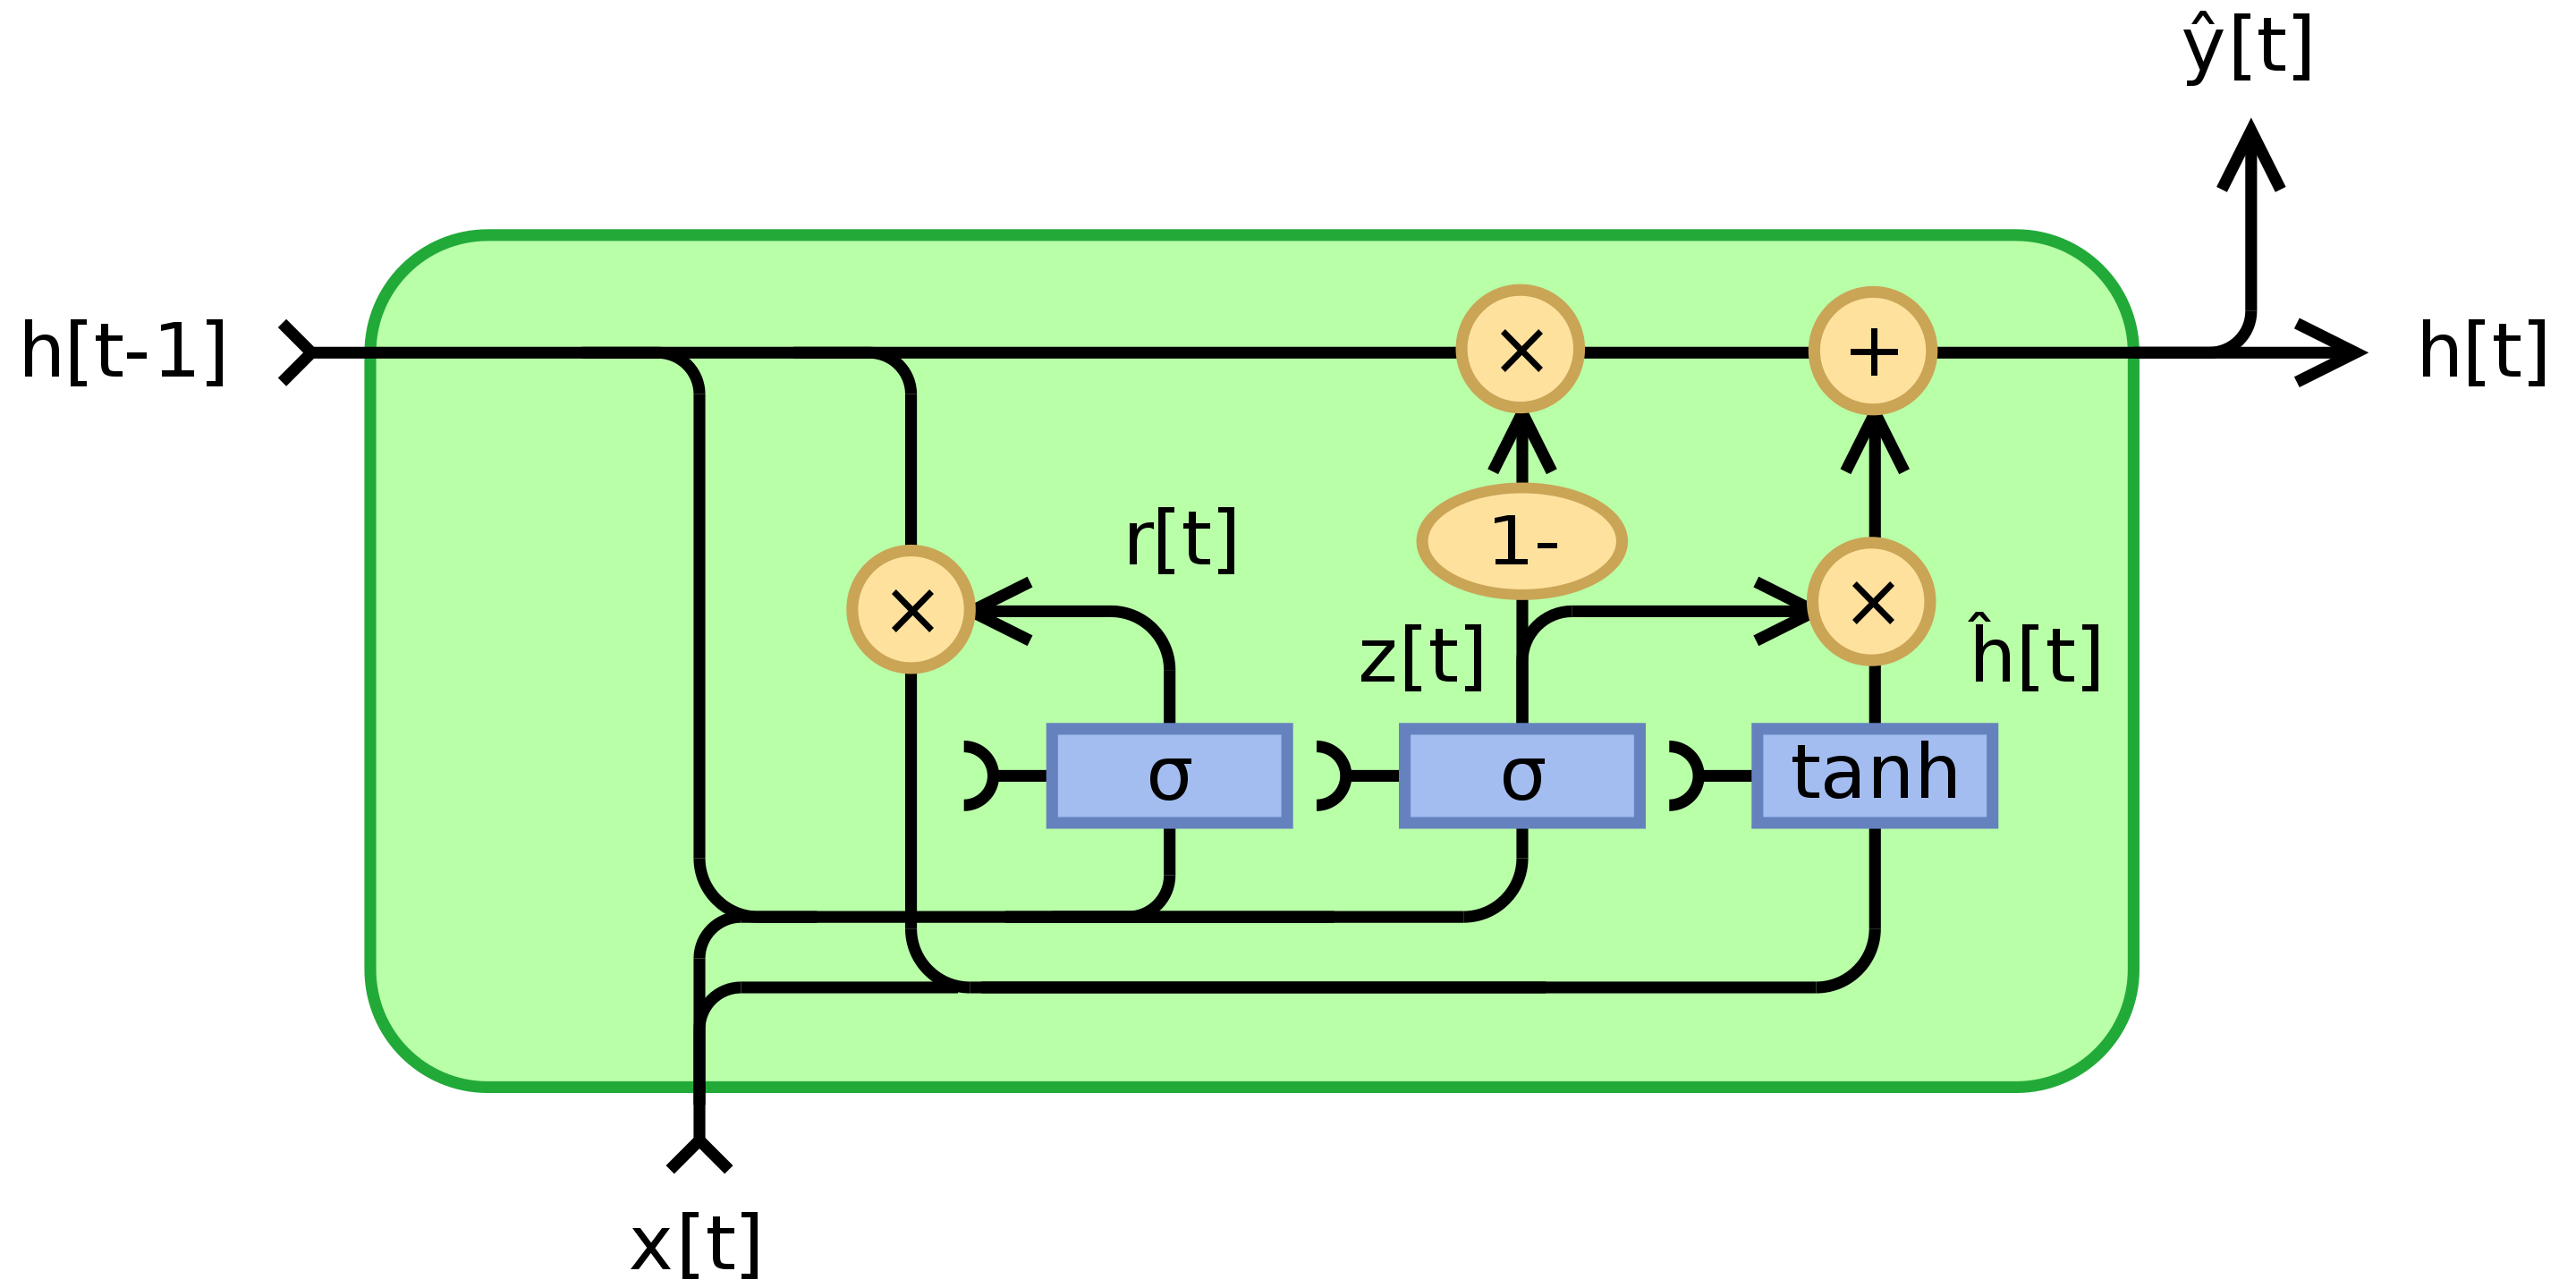

To learn more about GRU, please watch these short videos:

https://www.coursera.org/lecture/intro-to-deep-learning/modern-rnns-lstm-and-gru-WpduX

https://www.youtube.com/watch?v=pYRIOGTPRPU

Similar to the embedding layer, GRU module is not implemented in the Objax. The following is an implementation of the GRU cell in the Objax.

**Question 6[3 points]:** In the following implementation, complete the `__call__` function. 

In [8]:
class GRU(objax.Module):
    def __init__(self, nin: int, nout: int,
                 init_w: Callable = objax.nn.init.xavier_truncated_normal,
                 init_b: Callable = objax.nn.init.truncated_normal):
        self.update_w = objax.TrainVar(init_w((nin, nout)))
        self.update_u = objax.TrainVar(init_w((nout, nout)))
        self.update_b = objax.TrainVar(init_b((nout,), stddev=0.01))
        self.reset_w = objax.TrainVar(init_w((nin, nout)))
        self.reset_u = objax.TrainVar(init_w((nout, nout)))
        self.reset_b = objax.TrainVar(init_b((nout,), stddev=0.01))
        self.output_w = objax.TrainVar(init_w((nin, nout)))
        self.output_u = objax.TrainVar(init_w((nout, nout)))
        self.output_b = objax.TrainVar(init_b((nout,), stddev=0.01))

    def __call__(self, x: JaxArray, initial_state: JaxArray) -> Tuple[JaxArray, JaxArray]:
        def scan_op(state: JaxArray, x: JaxArray) -> JaxArray:  # State must come first for lax.scan

            update_gate = objax.functional.sigmoid(x.dot(self.update_w.value) + state.dot(self.update_u.value) +self.update_b.value) 

            reset_gate = objax.functional.sigmoid(x.dot(self.reset_w.value)+state.dot(self.reset_u.value) +self.reset_b.value)
            
            output_gate =  objax.functional.tanh(x.dot(self.output_w.value) + (reset_gate* state).dot(self.output_u.value) + self.output_b.value)
            
            #return update_gate * state + (1 - update_gate) * output_gate, 0  # we don't use the output, return 0.
            return (1-update_gate) * state + (update_gate) * output_gate, 0   # we don't use the output, return 0.

        return lax.scan(scan_op, initial_state, x.transpose((1, 0, 2)))[0]

**Questions 7** (bonus)[5 points]: With an example, explain in detail what does lax.scan function do, and what it is useful for?

Think of a function as a black box with inputs and outputs. `lax.scan` is a compiling function that takes in a function and utilizes a tracer variable to figure out what the function does, where it then works towards constructing a more optimal version of the function. 

For example, take an iterative function which depends on the previous step. Such functions can be optimized using lax.scan. One specific example is a [Cholesky matrix decomposition](https://www.geeksforgeeks.org/cholesky-decomposition-matrix-decomposition/), where we multiply matrices iteratively within a for loop. The lax.scan function can optimize the decomposition by speeding up the vector multiplications. It does this by replacing a for loop iterating over each multiplication with carry-over, thus improving the runtime. lax.scan carries over an object to the next loop and accumulates another object into an array such that it can replace a for loop with any carry over. 

Therefore, the function is useful to reduce compilation time of code. 


# The classifier 

The structure of the proposed classifier is as follows:


*   The input is a vector whose elements are integers in the interval $\{$1,...,max_vocab$\}$ of length max_len. In fact input is the one-hot encoding of each review.
*    Then, the embedding layer converts this vector into a matrix of size (max_len,embedding_size).
* Then, we feed each row of this matrix into the GRU cell. The size of the output vector of the GRU is num_hidden_units_GRU.
*  The output of the GRU is feed into a fully-connected layer with num_hidden_units neurons and ReLU activation function.

* Finally, we have the output layer which is a fully-connected layer with two outputs corresponding to the positive or negative label.



**Question 8** [3 points]: implement the described classifier using `objax.nn.Sequential`.




In [ ]:
# fill this in:z
gru_rnn = objax.nn.Sequential([
    Embed(size=max_len, latent=embedding_size),
    GRU(nin=embedding_size, nout=num_hidden_units_GRU),
    objax.nn.Linear(num_hidden_units_GRU, num_hidden_units),
    objax.functional.relu,
    objax.nn.Linear(num_hidden_units, 2)
])

You can print the structure as well as the number of the parameters of the each layer using the following line of codes.

In [ ]:
print(f'{" Network ":-^79}')
print(gru_rnn.vars())

----------------------------------- Network -----------------------------------
(Sequential)[0](Embed).w          6000 (200, 30)
(Sequential)[1](GRU).update_w      900 (30, 30)
(Sequential)[1](GRU).update_u      900 (30, 30)
(Sequential)[1](GRU).update_b       30 (30,)
(Sequential)[1](GRU).reset_w       900 (30, 30)
(Sequential)[1](GRU).reset_u       900 (30, 30)
(Sequential)[1](GRU).reset_b        30 (30,)
(Sequential)[1](GRU).output_w      900 (30, 30)
(Sequential)[1](GRU).output_u      900 (30, 30)
(Sequential)[1](GRU).output_b       30 (30,)
(Sequential)[2](Linear).b           60 (60,)
(Sequential)[2](Linear).w         1800 (30, 60)
(Sequential)[4](Linear).b            2 (2,)
(Sequential)[4](Linear).w          120 (60, 2)
+Total(14)                       13472


**Question 9** [3 points]: Draw the classifier architecture diagram. For GRU consider drawing the unrolled version. You do not need to draw the internal structure of the GRU. 

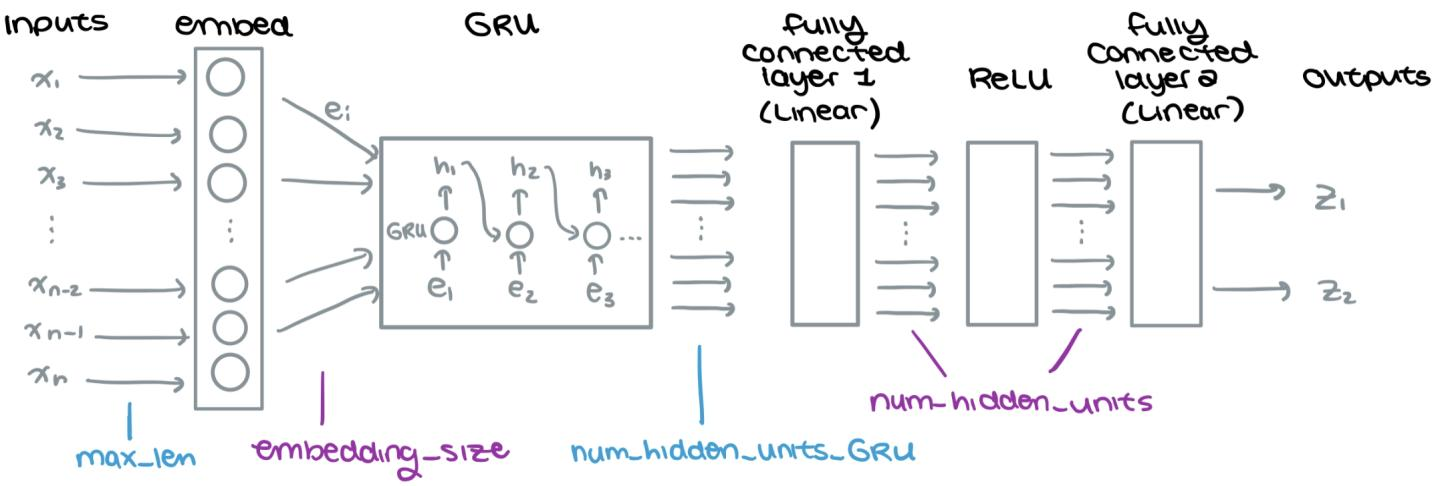

**Question 10**[1 point]: Construct an SGD optimizer using objax optimizers package.

In [ ]:
## Your implementaiton of the optimizer should go here
opt = objax.optimizer.SGD(gru_rnn.vars())

Then, we define the loss function, training operation function, and the
evaluation function.

In [ ]:
def loss_function(x: JaxArray, y: JaxArray):
    logits = gru_rnn(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU)))
    return objax.functional.loss.cross_entropy_logits_sparse(logits, y).sum()


gv = objax.GradValues(loss_function, gru_rnn.vars())


@objax.Function.with_vars(gv.vars() + opt.vars())
def train_op(x: JaxArray, y: JaxArray, lr: float):
    g, loss = gv(x, y)
    opt(lr, g)
    return loss


train_op = objax.Jit(train_op)
eval_op = objax.Jit(lambda x: gru_rnn(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU))),
                    gru_rnn.vars())


The next function is a helper for computing the accuracy.

In [ ]:
def accuracy(data_loader):
    """Compute the accuracy for a provided data loader"""
    acc_total = 0
    x, y = data_loader
    batch_size_acc = 500
    for batch_idx in np.array_split(np.arange(len(x)), len(x) // batch_size_acc):
        x_batch, target_class = x[batch_idx], y[batch_idx]
        predicted_class = eval_op(x_batch).argmax(1)
        acc_total += (predicted_class == target_class).sum()
    return acc_total / len(x)

**Question 11** [4 points]: Write the training loop to train the model. In each epoch, record the training accuracy and the validation accuracy. Also, at the end of the training report the accuracy on the test set. Please use the training set to train the model, the validation set to monitor accuracy during training, and then the test set once after training is complete to measure the final generalization of the model.

**Question 12:[1 points]**  Plot the training accuracy and the validation accuracy versus the number of epochs. What is the generalization gap between the test and training?

In [ ]:
learning_rate = 1e-3 # learning rate
num_epochs = 20 # number of epochs
batch_size = 250  # batch size
training_data = (messages_train, labels_train)
validation_data = (messages_valid, labels_valid)
test_data = (messages_test, labels_test)

Epoch 0001  Training Loss 172.43 Validation Loss 171.80 Training Accuracy 54.51 Validation Accuracy 54.52
Epoch 0002  Training Loss 171.16 Validation Loss 170.12 Training Accuracy 56.53 Validation Accuracy 55.92
Epoch 0003  Training Loss 169.34 Validation Loss 166.08 Training Accuracy 58.58 Validation Accuracy 60.40
Epoch 0004  Training Loss 167.41 Validation Loss 162.56 Training Accuracy 60.48 Validation Accuracy 62.58
Epoch 0005  Training Loss 164.54 Validation Loss 157.06 Training Accuracy 61.91 Validation Accuracy 65.08
Epoch 0006  Training Loss 162.43 Validation Loss 159.56 Training Accuracy 63.50 Validation Accuracy 65.26
Epoch 0007  Training Loss 159.86 Validation Loss 156.16 Training Accuracy 65.07 Validation Accuracy 65.48
Epoch 0008  Training Loss 159.00 Validation Loss 151.84 Training Accuracy 65.45 Validation Accuracy 67.22
Epoch 0009  Training Loss 157.25 Validation Loss 148.61 Training Accuracy 66.65 Validation Accuracy 69.42
Epoch 0010  Training Loss 155.23 Validation Lo

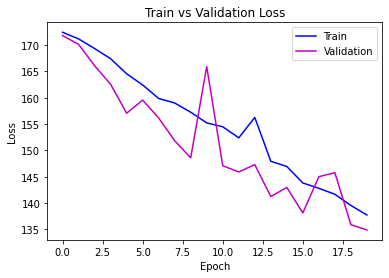

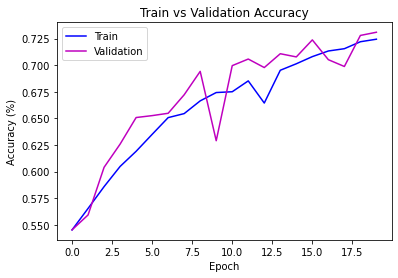

In [ ]:
# you code for the training loop should start here 
avg_train_loss_epoch = []
avg_val_loss_epoch = []
train_acc_epoch = []
val_acc_epoch = []

for epoch in range(num_epochs):
    avg_train_loss = 0 # (averaged) training loss per batch
    avg_val_loss =  0  # (averaged) validation loss per batch
    train_acc = 0      # training accuracy per batch
    val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
    train_indices = np.arange(len(messages_train)) 
    np.random.shuffle(train_indices)
    for it in range(0, messages_train.shape[0], batch_size):
        batch = train_indices[it: it+batch_size] ## 2.2
        avg_train_loss += float(train_op(messages_train[batch], labels_train[batch], learning_rate)[0]) * len(batch)
        train_prediction = eval_op(messages_train[batch]).argmax(1)
        train_acc += (np.array(train_prediction).flatten() == labels_train[batch]).sum()
    train_acc_epoch.append(train_acc/messages_train.shape[0])
    avg_train_loss_epoch.append(avg_train_loss/messages_train.shape[0])

      # run validation
    val_indices = np.arange(len(messages_valid)) 
    np.random.shuffle(val_indices)    
    for it in range(0, messages_valid.shape[0], batch_size):
        batch = val_indices[it: it+batch_size] ## 2.2
        avg_val_loss += float(loss_function(messages_valid[batch], labels_valid[batch])) * len(batch)
        val_prediction = eval_op(messages_valid[batch]).argmax(1)
        val_acc += (np.array(val_prediction).flatten() == labels_valid[batch]).sum()
    val_acc_epoch.append(val_acc/messages_valid.shape[0])
    avg_val_loss_epoch.append(avg_val_loss/messages_valid.shape[0])

    print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/messages_train.shape[0], avg_val_loss/messages_valid.shape[0], 100*train_acc/messages_train.shape[0], 100*val_acc/messages_valid.shape[0]))
  
  #Plot training loss
plt.title("Train vs Validation Loss")
plt.plot(avg_train_loss_epoch,color='blue', label="Train")
plt.plot(avg_val_loss_epoch, color='m', label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

plt.title("Train vs Validation Accuracy")
plt.plot(train_acc_epoch, color = 'blue', label="Train")
plt.plot(val_acc_epoch, color='m', label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend(loc='best')
plt.show()

### Testing

In [ ]:
# run test set
avg_test_loss = 0  # (averaged) test loss per batch
test_acc = 0       # testing accuracy per batch

test_indices = np.arange(len(messages_test)) 
np.random.shuffle(test_indices)

for it in range(0, messages_test.shape[0], batch_size):
    batch = test_indices[it: it+batch_size] ## 2.2
    avg_test_loss += float(loss_function(messages_test[batch], labels_test[batch])) * len(batch)
    test_prediction = eval_op(messages_test[batch]).argmax(1)
    test_acc += (np.array(test_prediction).flatten() == labels_test[batch]).sum()
print('Testing Accuracy %.2f' % (100*test_acc/messages_test.shape[0]))


Testing Accuracy 72.66



*The generalization gap:* The difference between the highest training accuracy of 72.44 and the testing accuracy of 72.66 is 0.22. 
Therefore, since they are very close in accuracy on the testing set and test set, the model generalizes well and has a small generalization gap. 

# Comparing SGD with Adam

**Question 13** [4 points]: Train the same model with the same parameters using the Adam optimizer instead of the SGD. Do not forgot to initialize the network before training, otherwise the previous model will continue training from the final model parameters rather than start from a fresh set of random weight initialization values.

In [ ]:
# Define (again) your model here
gru_rnn2 = objax.nn.Sequential([
   Embed(size=max_len, latent=embedding_size),
   GRU(nin=embedding_size, nout=num_hidden_units_GRU),
    objax.nn.Linear(num_hidden_units_GRU, num_hidden_units),
    objax.functional.relu,
    objax.nn.Linear(num_hidden_units, 2)
])

In [ ]:
## Your implementaiton of the optimizer should go here
opt2 = objax.optimizer.Adam(gru_rnn2.vars())

You will also need the following functions.

In [ ]:
def loss_function(x: JaxArray, y: JaxArray):
    logits = gru_rnn2(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU)))
    return objax.functional.loss.cross_entropy_logits_sparse(logits, y).sum()


gv2 = objax.GradValues(loss_function, gru_rnn2.vars())


@objax.Function.with_vars(gv2.vars() + opt2.vars())
def train_op(x: JaxArray, y: JaxArray, lr: float):
    g, loss = gv2(x, y)
    opt2(lr, g)
    return loss


train_op = objax.Jit(train_op)
eval_op = objax.Jit(lambda x: gru_rnn2(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU))),
                    gru_rnn2.vars())

In [ ]:
learning_rate = 1e-3
num_epochs = 20
batch_size = 250 
training_data = (messages_train, labels_train)
validation_data = (messages_valid, labels_valid)
test_data = (messages_test, labels_test)


**Question 14** [1 points]: Plot the training accuracy and validation accuracy versus the epochs, and compare your results with the case that you trained the network using SGD. What is the generalization gap for this case?

Epoch 0001  Training Loss 159.48 Validation Loss 135.23 Training Accuracy 62.19 Validation Accuracy 73.40
Epoch 0002  Training Loss 133.76 Validation Loss 135.78 Training Accuracy 73.88 Validation Accuracy 73.32
Epoch 0003  Training Loss 130.99 Validation Loss 128.33 Training Accuracy 74.61 Validation Accuracy 75.40
Epoch 0004  Training Loss 131.46 Validation Loss 124.64 Training Accuracy 74.15 Validation Accuracy 75.46
Epoch 0005  Training Loss 130.72 Validation Loss 127.69 Training Accuracy 73.99 Validation Accuracy 74.40
Epoch 0006  Training Loss 130.78 Validation Loss 131.01 Training Accuracy 73.84 Validation Accuracy 74.14
Epoch 0007  Training Loss 126.83 Validation Loss 124.91 Training Accuracy 75.17 Validation Accuracy 75.62
Epoch 0008  Training Loss 125.22 Validation Loss 122.33 Training Accuracy 75.41 Validation Accuracy 76.24
Epoch 0009  Training Loss 123.48 Validation Loss 120.84 Training Accuracy 75.95 Validation Accuracy 76.60
Epoch 0010  Training Loss 122.98 Validation Lo

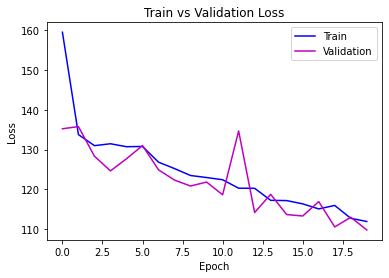

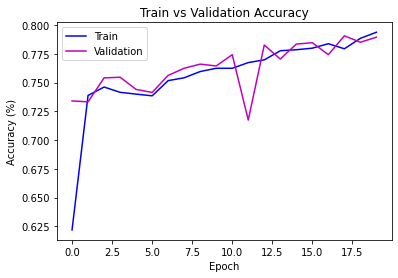

In [ ]:
# you code for the training loop should start here 
avg_train_loss_epoch = []
avg_val_loss_epoch = []
train_acc_epoch = []
val_acc_epoch = []

for epoch in range(num_epochs):
    avg_train_loss = 0 # (averaged) training loss per batch
    avg_val_loss =  0  # (averaged) validation loss per batch
    train_acc = 0      # training accuracy per batch
    val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
    train_indices = np.arange(len(messages_train)) 
    np.random.shuffle(train_indices)
    for it in range(0, messages_train.shape[0], batch_size):
        batch = train_indices[it: it+batch_size] ## 2.2
        avg_train_loss += float(train_op(messages_train[batch], labels_train[batch], learning_rate)[0]) * len(batch)
        train_prediction = eval_op(messages_train[batch]).argmax(1)
        train_acc += (np.array(train_prediction).flatten() == labels_train[batch]).sum()
    train_acc_epoch.append(train_acc/messages_train.shape[0])
    avg_train_loss_epoch.append(avg_train_loss/messages_train.shape[0])

      # run validation
    val_indices = np.arange(len(messages_valid)) 
    np.random.shuffle(val_indices)    
    for it in range(0, messages_valid.shape[0], batch_size):
        batch = val_indices[it: it+batch_size] ## 2.2
        avg_val_loss += float(loss_function(messages_valid[batch], labels_valid[batch])) * len(batch)
        val_prediction = eval_op(messages_valid[batch]).argmax(1)
        val_acc += (np.array(val_prediction).flatten() == labels_valid[batch]).sum()
    val_acc_epoch.append(val_acc/messages_valid.shape[0])
    avg_val_loss_epoch.append(avg_val_loss/messages_valid.shape[0])

    print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/messages_train.shape[0], avg_val_loss/messages_valid.shape[0], 100*train_acc/messages_train.shape[0], 100*val_acc/messages_valid.shape[0]))
  
  #Plot training loss
plt.title("Train vs Validation Loss")
plt.plot(avg_train_loss_epoch,color='blue', label="Train")
plt.plot(avg_val_loss_epoch, color='m', label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

plt.title("Train vs Validation Accuracy")
plt.plot(train_acc_epoch, color = 'blue', label="Train")
plt.plot(val_acc_epoch, color='m', label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend(loc='best')
plt.show()

In [ ]:
# run test set
avg_test_loss = 0  # (averaged) test loss per batch
test_acc = 0       # testing accuracy per batch

test_indices = np.arange(len(messages_test)) 
np.random.shuffle(test_indices)

for it in range(0, messages_test.shape[0], batch_size):
    batch = test_indices[it: it+batch_size] ## 2.2
    avg_test_loss += float(loss_function(messages_test[batch], labels_test[batch])) * len(batch)
    test_prediction = eval_op(messages_test[batch]).argmax(1)
    test_acc += (np.array(test_prediction).flatten() == labels_test[batch]).sum()
print('Testing Accuracy %.2f' % (100*test_acc/messages_test.shape[0]))


Testing Accuracy 78.30


*Compared to SGD:* Adam performs better with the highest validation accuracy of 79.06 at epoch 18 (compared to SGD with highest validation accuracy of 73.1 at epoch 20). 


*The generalization gap:* The difference between the highest training accuracy of 79.37 and the testing accuracy of 78.30 is 1.07. 
Therefore, since they are  close in accuracy on the testing set compared to the test set, the model generalizes relatively well and has a small generalization gap. 

**Questions 15** [1 points]: Briefly explain how Adam optimizer works and compare it with the SGD optimizaer.

The SGD  optimizer updates parameters by taking the gradient with respect to the parameters in combination with a static learning rate. It analyses single training examples at a time for each of these updates, which does not take advantage of vectorization. Compared to SGD, the Adam optimizer utilizes different learning rates per parameter via an adaptive learning rate method. It uses estimations of the first and second moments of gradient to update the learning rate for each weight, which is then used to update the parameters. As such, it is similar to SGD but with additional methods. 

# Early Stopping

**Questions 16** [3 points]: 
This time implement the early stopping method with a patience window. All the parameters are the same as the previous section. Also, set the patience window to 5 epochs.

In [9]:
# Your implementation of the model should go here
gru_rnn3 = objax.nn.Sequential([
   Embed(size=max_len, latent=embedding_size),
   GRU(nin=embedding_size, nout=num_hidden_units_GRU),
   objax.nn.Linear(num_hidden_units_GRU, num_hidden_units),
   objax.functional.relu,
   objax.nn.Linear(num_hidden_units, 2)
])

In [10]:
## Your implementation of the optimizer should go here
opt3 = objax.optimizer.Adam(gru_rnn3.vars())

You will also need the following functions.

In [11]:
def loss_function(x: JaxArray, y: JaxArray):
    logits = gru_rnn3(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU)))
    return objax.functional.loss.cross_entropy_logits_sparse(logits, y).sum()


gv3 = objax.GradValues(loss_function, gru_rnn3.vars())


@objax.Function.with_vars(gv3.vars() + opt3.vars())
def train_op(x: JaxArray, y: JaxArray, lr: float):
    g, loss = gv3(x, y)
    opt3(lr, g)
    return loss


train_op = objax.Jit(train_op)
eval_op = objax.Jit(lambda x: gru_rnn3(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU))),
                    gru_rnn3.vars())

In [12]:
learning_rate = 1e-3
num_epochs = 20
batch_size = 250 
max_patience_window = 5
training_data = (messages_train, labels_train)
validation_data = (messages_valid, labels_valid)
test_data = (messages_test, labels_test)

### Training and validation

Epoch 0001  Training Loss 109.91 Validation Loss 110.22 Training Accuracy 79.66 Validation Accuracy 79.18
Epoch 0002  Training Loss 111.17 Validation Loss 108.36 Training Accuracy 79.25 Validation Accuracy 79.38
Epoch 0003  Training Loss 110.55 Validation Loss 114.71 Training Accuracy 79.42 Validation Accuracy 78.12
Epoch 0004  Training Loss 109.81 Validation Loss 112.93 Training Accuracy 79.86 Validation Accuracy 79.06
Epoch 0005  Training Loss 109.22 Validation Loss 109.26 Training Accuracy 79.92 Validation Accuracy 78.70
Epoch 0006  Training Loss 107.85 Validation Loss 110.35 Training Accuracy 80.21 Validation Accuracy 79.08
Epoch 0007  Training Loss 106.93 Validation Loss 111.76 Training Accuracy 80.39 Validation Accuracy 78.48
Epoch 0008  Training Loss 106.47 Validation Loss 109.64 Training Accuracy 80.54 Validation Accuracy 79.74


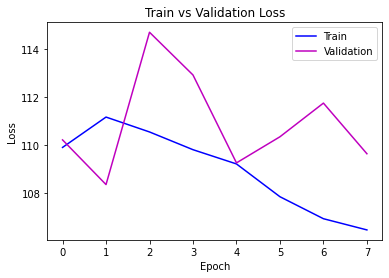

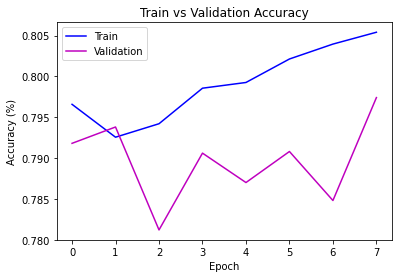

In [16]:
avg_train_loss_epoch = []
avg_val_loss_epoch = []
train_acc_epoch = []
val_acc_epoch = []
# for early stopping
counter = 0
max_loss = 0

for epoch in range(num_epochs):
    avg_train_loss = 0 # (averaged) training loss per batch
    avg_val_loss =  0  # (averaged) validation loss per batch
    train_acc = 0      # training accuracy per batch
    val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
    train_indices = np.arange(len(messages_train)) 
    np.random.shuffle(train_indices)
    for it in range(0, messages_train.shape[0], batch_size):
        batch = train_indices[it: it+batch_size] ## 2.2
        avg_train_loss += float(train_op(messages_train[batch], labels_train[batch], learning_rate)[0]) * len(batch)
        train_prediction = eval_op(messages_train[batch]).argmax(1)
        train_acc += (np.array(train_prediction).flatten() == labels_train[batch]).sum()
    train_acc_epoch.append(train_acc/messages_train.shape[0])
    avg_train_loss_epoch.append(avg_train_loss/messages_train.shape[0])

      # run validation
    val_indices = np.arange(len(messages_valid)) 
    np.random.shuffle(val_indices)    
    for it in range(0, messages_valid.shape[0], batch_size):
        batch = val_indices[it: it+batch_size] ## 2.2
        avg_val_loss += float(loss_function(messages_valid[batch], labels_valid[batch])) * len(batch)
        val_prediction = eval_op(messages_valid[batch]).argmax(1)
        val_acc += (np.array(val_prediction).flatten() == labels_valid[batch]).sum()
    val_acc_epoch.append(val_acc/messages_valid.shape[0])
    avg_val_loss_epoch.append(avg_val_loss/messages_valid.shape[0])

    print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/messages_train.shape[0], avg_val_loss/messages_valid.shape[0], 100*train_acc/messages_train.shape[0], 100*val_acc/messages_valid.shape[0]))

    ### Early stopping implementation ###
    if avg_val_loss/messages_valid.shape[0] > max_loss:
      max_loss = avg_val_loss/messages_valid.shape[0]
      counter = 0
    else:
      counter+=1
    if counter == max_patience_window: # max validation loss has been the same for 5 epochs
      break

  
  #Plot training loss
plt.title("Train vs Validation Loss")
plt.plot(avg_train_loss_epoch,color='blue', label="Train")
plt.plot(avg_val_loss_epoch, color='m', label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

plt.title("Train vs Validation Accuracy")
plt.plot(train_acc_epoch, color = 'blue', label="Train")
plt.plot(val_acc_epoch, color='m', label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend(loc='best')
plt.show()

### Testing

In [17]:
# run test set
avg_test_loss = 0  # (averaged) test loss per batch
test_acc = 0       # testing accuracy per batch

test_indices = np.arange(len(messages_test)) 
np.random.shuffle(test_indices)

for it in range(0, messages_test.shape[0], batch_size):
    batch = test_indices[it: it+batch_size] ## 2.2
    avg_test_loss += float(loss_function(messages_test[batch], labels_test[batch])) * len(batch)
    test_prediction = eval_op(messages_test[batch]).argmax(1)
    test_acc += (np.array(test_prediction).flatten() == labels_test[batch]).sum()
print('Testing Accuracy %.2f' % (100*test_acc/messages_test.shape[0]))


Testing Accuracy 79.68


**Question 16**[1 points]: Report the best validation accuracy and the test accuracy of your best model.

The best validation accuracy is 79.74 at epoch 7, and the best test accuracy is 79.68. 